# Florida Man

Every day, another absurd headline starts with “Florida Man…” and the internet points, laughs, and asks what the hell is wrong with this state. But “Florida Man” isn’t a person. It’s a meme *about* a person, built on the simple assumption that Florida produces more bizarre incidents than anywhere else in the US. The common rebuttal is also simple: Florida isn’t necessarily stranger, it just reports everything faster.

Thanks to the state's broad Sunshine Laws (Chapter 119), arrest records and incident reports in Florida become public almost immediately. Journalists love it because they can write “Florida Man…” within hours of arrest. So, it's not that other states don't have similarly bizzare crimes; we just don’t hear about “Ohio Man” as much due to the state's differing laws.

This project tests the premise instead of the stereotype. It scrapes “Florida Man” and “Florida Woman” headlines from the r/FloridaMan subReddit, then sorts them into four recurring themes: animals, nudity, substances, weapons. Dates and locations are extracted when available. The goal is straightforward: collect enough samples to see if the meme holds up. Do the stories actually cluster around those themes, or is it just confirmation bias?

Run the notebook top to bottom.



## Sources

- `kaggle_florida_man.csv` — historical dump (covers ~2014 through 2022-04-30)
- **r/FloridaMan** — Reddit JSON listing API (from 2022-05-01 onward), with automatic Pushshift backfill if the listing API stops early


In [1]:
import time, re, sys
from datetime import datetime
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt


HEADERS = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'}
TIMEOUT = 20
PAUSE = 1.2  # politeness delay

# regex rules for tagging — EXPANDED to catch more Florida Man tropes
ANIMAL_RE   = re.compile(r'(gator|alligator|python|bear|dog|cat|bird|iguana|snake|croc|crocodile|monkey|raccoon|goat|llama|chicken|rooster|horse|cow|bull|boar|hog|pig|shark|deer|possum|squirrel|peacock|duck|turkey|flamingo|otter|panther|cougar|bobcat|coyote|fox|rat|mice|mouse|bat|frog|toad|turtle|tortoise|lizard|wildlife|pet|animal|zoo|farm)', re.I)
NUDITY_RE   = re.compile(r'(naked|nude|topless|undressed|streak|streaking|pantsless|without\s+pants|without\s+shirt|underwear|boxer|brief|exposed|exposure|indecent|lewd|sex|sexual|prostitut|strip|genitals?|penis|vagina|breasts?|masturbat)', re.I)
SUBSTANCE_RE= re.compile(r'(beer|alcohol|drunk|intoxicated|DUI|DWI|drug|meth|methamphetamine|cocaine|crack|heroin|fentanyl|opioid|weed|marijuana|cannabis|high|stoned|liquor|vodka|whiskey|wine|booze|substance|pill|narcotic|dope|sober|sobriety|rehab|bong|joint|edible|smoke|smoking|vape|vaping)', re.I)
WEAPON_RE   = re.compile(r'(gun|rifle|shotgun|knife|sword|machete|grenade|taser|weapon|pistol|firearm|blade|ax|axe|hatchet|bat|club|baton|brass\s+knuckles|nunchuck|bow|arrow|crossbow|spear|armed|shoot|shooting|shot|stab|stabbing|slashing|assault\s+rifle|handgun|revolver|ammunition|ammo|bullet)', re.I)

# loosened filter: match "florida man" OR "florida woman" anywhere in the text
FL_PERSON_RE = re.compile(r'florida\s+(man|woman)', re.I)

# spam/noise filter — catch posts that aren't actual Florida Man stories
SPAM_PATTERNS = [
    # Sexual solicitation / hookup spam
    r'(?:message|dm|hit)\s*(?:me|up)\s*(?:on|@)',
    r'(?:snap|snapchat|instagram|insta|telegram|whatsapp|kik)\s*[:\-]?\s*\w+',
    r'available\s+to\s+(?:fuck|hook\s*up|meet)',
    r'(?:add|text|hmu)\s+(?:me|my)\s+(?:snap|insta|number)',
    r'looking\s+for\s+(?:fun|hookup|fwb)',
    r'(?:onlyfans|of)\s*[:\-@]',
    # Giveaways / scams
    r'(?:free|new)\s*(?:iphone|samsung|gift\s*card|giveaway)',
    r'giveaway',
    r'click\s+(?:here|link|below)',
    r'(?:win|claim)\s+(?:a|your|free)',
    # Political commentary (not news stories)
    r'^(?:lawrence|maddow|hannity|tucker|opinion)[:\s]',
    r'\$\d+\s*(?:billion|million)\s+stupider',
    # Social media crossposts that aren't news
    r'on\s+twitter$',
    r'#\w+wild\b',  # sports hashtags
    # Generic spam indicators
    r'^(?:am|i\'m)\s+available',
    r'(?:subscribe|follow)\s+(?:for|to)\s+(?:more|daily)',
    # Meme/joke posts (not news)
    r'florida\s+man\.{2,}',  # "Florida man..." with ellipsis (low-effort memes)
    r'👏{2,}',  # clap emoji spam
    r'🔥{2,}',  # fire emoji spam
    # Meta / promotional posts (not actual stories)
    r'florida\s+man\s+report.*facebook',  # Facebook page promotions
    r'news\s*&\s*stories\s+from\s+florida',  # promotional descriptions
    r'pulling\s+in.*reports\s+from',  # aggregator descriptions
    # Personal rants / dating stories (not news)
    r'\bI\s+met\s+him\b',  # personal dating stories
    r'\bgo\s+fuck\s+yourself\b',  # personal rants
    r'\bpiece\s+of\s+shit\b',  # personal rants
    r'\bswingers?\s+site\b',  # personal stories
    r'\bwhich\s+lead\s+to\s+sex\b',  # personal stories
    # Gibberish / word salad
    r'\bchildren\s+are\s+what\s+is\s+my\s+nice\b',  # specific gibberish post
    r'\binconspicuous\s+wheelbarrow\b',  # gibberish indicator
    r'\bgingerbread\s+new\s+england\b',  # gibberish indicator
]
SPAM_RE = re.compile('|'.join(SPAM_PATTERNS), re.I)

def is_valid_florida_story(headline: str) -> bool:
    """Check if headline is a valid Florida Man/Woman story (not spam/noise)."""
    if not headline:
        return False
    # Must contain "Florida Man" or "Florida Woman"
    if not FL_PERSON_RE.search(headline):
        return False
    # Must NOT match spam patterns
    if SPAM_RE.search(headline):
        return False
    # Very short headlines are usually spam or crossposts
    if len(headline) < 25:
        return False
    # Too many emojis = probably a meme, not news
    emoji_count = len(re.findall(r'[\U0001F300-\U0001F9FF]', headline))
    if emoji_count > 3:
        return False
    return True

# florida cities/counties for geo-tagging
FL_CITIES = [
    'Miami','Orlando','Tampa','Jacksonville','Tallahassee','St. Petersburg','Saint Petersburg','Fort Lauderdale','Hialeah','Pembroke Pines','Hollywood','Gainesville','Boca Raton','Sarasota','Naples','Fort Myers','Pensacola','Daytona Beach','St. Augustine','Saint Augustine','Clearwater','Ocala','Lakeland','Winter Park','Kissimmee','Delray Beach','West Palm Beach','Palm Beach','Coral Gables','Key West','Panama City','Port St. Lucie','Port Saint Lucie','Sanford','Boynton Beach','Cape Coral','Bradenton','Plantation','Pompano Beach','Deerfield Beach','North Miami','Homestead','Aventura','Doral','Margate','Davie','Miramar','Sunrise','Coral Springs','Coconut Creek','Jupiter','Palm Bay','Melbourne','Vero Beach','Stuart','Lake Worth','Lake Worth Beach','Fort Pierce','Apopka','Altamonte Springs','Clermont','Winter Garden','Winter Haven','Bartow','Brandon','Wesley Chapel','New Port Richey','Spring Hill','Brooksville','The Villages','Leesburg','Inverness','Sebring','Okeechobee','Key Largo','Islamorada','Marco Island','Bonita Springs','Estero','Ocala','Sebring','Okeechobee']

FL_COUNTIES = [
    'Miami-Dade','Broward','Palm Beach','Hillsborough','Orange','Pinellas','Duval','Lee','Polk','Brevard','Volusia','Pasco','Seminole','Sarasota','Manatee','Lake','Collier','Leon','Alachua','Escambia','Marion','St. Lucie','Saint Lucie','Bay','Osceola','Charlotte','Clay','Hernando','Santa Rosa','St. Johns','Saint Johns','Okaloosa','Walton','Indian River','Highlands','Nassau','Flagler','Citrus','Suwannee','Okeechobee','Martin','Monroe']

## Trope definitions

- **Animals**: wildlife, pets, farm animals, reptiles (zoo, pet, wildlife, etc.)
- **Nudity**: sexual acts, prostitution, indecent exposure (sex, sexual, prostitution, etc.)
- **Substances**: specific drugs, smoking/vaping, rehab terms (meth, heroin, pill, vape, etc.)
- **Weapons**: blunt objects, actions (stab, shoot), ammunition (bat, club, shooting, bullet, etc.)

Some people get really creative with their crimes. But I'll get to that later.

In [2]:

def get_soup(url):
    r = requests.get(url, headers=HEADERS, timeout=TIMEOUT)
    r.raise_for_status()
    return BeautifulSoup(r.text, 'lxml')

def clean_text(s):
    if not s:
        return ''
    return re.sub(r'\s+', ' ', s).strip()

def extract_category_flags(txt: str):
    return {
        'has_animals': bool(ANIMAL_RE.search(txt or '')),
        'has_nudity': bool(NUDITY_RE.search(txt or '')),
        'has_substances': bool(SUBSTANCE_RE.search(txt or '')),
        'has_weapons': bool(WEAPON_RE.search(txt or '')),
    }

def fetch_article_text(url):
    """Fetch article HTML and return combined title/body text (best-effort)."""
    if not url or 'reddit.com' in url or 'redd.it' in url:
        return None
    try:
        soup = get_soup(url)
    except Exception:
        return None
    parts = []
    if soup.title and soup.title.text:
        parts.append(clean_text(soup.title.text))
    paras = soup.find_all('p')
    for p in paras[:80]:
        txt = clean_text(p.text)
        if txt:
            parts.append(txt)
    return ' '.join(parts) if parts else None

def infer_location_hint(*texts):
    """Extract location using Florida city/county gazetteer; fallback to 'Florida' if none found."""
    combined = ' '.join([t for t in texts if t])
    if not combined:
        return 'Florida'

    # Check cities first (sorted by length to match longer names first)
    for city in sorted(FL_CITIES, key=len, reverse=True):
        if re.search(r'\b' + re.escape(city) + r'\b', combined, re.I):
            return f"{city}, FL"

    # Check counties (sorted by length to match longer names first)
    for county in sorted(FL_COUNTIES, key=len, reverse=True):
        # Match "County" or "Co." or just the county name with word boundaries
        if re.search(r'\b' + re.escape(county) + r'(?:\s+(?:County|Co\.?))?\b', combined, re.I):
            return f"{county} County, FL"

    return 'Florida'

def parse_date(soup, url):
    sel = [
        ('meta', {'property':'article:published_time'}, 'content'),
        ('meta', {'name':'pubdate'}, 'content'),
        ('meta', {'name':'date'}, 'content'),
        ('meta', {'itemprop':'datePublished'}, 'content'),
    ]
    for tag, attrs, attr_name in sel:
        el = soup.find(tag, attrs)
        if el and el.get(attr_name):
            return el.get(attr_name)
    t = soup.find('time')
    if t and (t.get('datetime') or t.text):
        return t.get('datetime') or clean_text(t.text)
    return None


## Main functions

Since the meme exploded around 2013, that’s the earliest point worth scraping. Reddit’s native API can’t reach that far back in bulk, so we rely on a Pushshift-compatible mirror (pullpush.io) that still exposes historical data in the old Pushshift format. It gives us full access to r/FloridaMan posts going back to 2013 so we can collect everything at once.

Once the data starts coming in, the helper functions handle the dull but necessary work: fetching web pages, cleaning text, checking if a headline fits the trope, and trying to pull out a location. Most headlines don’t name a city or county, so we scan the article body as well. If that still isn’t enough, we fetch the linked article and search it against a list of 47 Florida cities and 29 counties. If we still can’t pin it down, we label it as “Florida” and move on.

In [3]:

def scrape_reddit_floridaman_listing(max_pages=10, start_date=None, log_every=1):
    """Scrape r/FloridaMan using Reddit's JSON listing API (no Pushshift), with simple progress logs."""
    rows = []
    after = None
    cutoff_ts = None
    if start_date:
        from datetime import datetime, timezone
        dt = datetime.fromisoformat(start_date) if isinstance(start_date, str) else start_date
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        cutoff_ts = int(dt.timestamp())

    for page in range(max_pages):
        url = 'https://www.reddit.com/r/FloridaMan.json'
        params = {'limit': 100}
        if after:
            params['after'] = after
        try:
            r = requests.get(url, headers=HEADERS, params=params, timeout=TIMEOUT)
            r.raise_for_status()
            data = r.json()
        except Exception as e:
            print(f"  reddit error on page {page+1}: {e}")
            break

        posts = data.get('data', {}).get('children', [])
        if not posts:
            break

        added_this_page = 0
        for post in posts:
            p = post.get('data', {})
            title = p.get('title', '') or ''
            if not title or not FL_PERSON_RE.search(title):
                continue

            created = p.get('created_utc')
            if cutoff_ts is not None and created is not None and created < cutoff_ts:
                continue

            selftext = p.get('selftext', '') or ''
            body = f"{title} {selftext}"

            location_hint = infer_location_hint(title, selftext)
            flags = extract_category_flags(body)

            date_str = None
            if created:
                from datetime import datetime, timezone
                date_str = datetime.fromtimestamp(created, tz=timezone.utc).isoformat()

            permalink = f"https://www.reddit.com{p.get('permalink','')}"
            rows.append({
                'headline': title,
                'date': date_str,
                'snippet': selftext[:200] if selftext else '',
                'source': 'r/FloridaMan',
                'location_hint': location_hint,
                **flags,
                'source_url': permalink,
            })
            added_this_page += 1

        if log_every and ((page + 1) % log_every == 0):
            print(f"  page {page+1}: fetched {len(posts)} posts, kept {added_this_page}, total kept {len(rows)}")

        after = data.get('data', {}).get('after')
        if not after:
            break
        time.sleep(PAUSE)

    return rows


def scrape_reddit_floridaman_pushshift(start_date='2013-01-01', batch_size=500, max_loops=200, max_results=50000, log_every=1):
    """Pushshift-compatible scraper for backfill when listing pagination caps out."""
    rows = []
    from datetime import datetime, timezone

    cutoff_dt = datetime.fromisoformat(start_date) if isinstance(start_date, str) else start_date
    if cutoff_dt.tzinfo is None:
        cutoff_dt = cutoff_dt.replace(tzinfo=timezone.utc)
    else:
        cutoff_dt = cutoff_dt.astimezone(timezone.utc)
    cutoff_ts = int(cutoff_dt.timestamp())

    before = None
    total_calls = 0
    base_url = 'https://api.pullpush.io/reddit/search/submission'

    while total_calls < max_loops and len(rows) < max_results:
        params = {
            'subreddit': 'FloridaMan',
            'sort': 'desc',
            'sort_type': 'created_utc',
            'size': batch_size,
            'after': cutoff_ts,
        }
        if before:
            params['before'] = before

        try:
            r = requests.get(base_url, headers=HEADERS, params=params, timeout=TIMEOUT)
            r.raise_for_status()
            data = r.json()
            posts = data.get('data', [])
        except Exception as e:
            print(f"  pushshift error on batch {total_calls+1}: {e}")
            break

        total_calls += 1
        if not posts:
            break

        added_this_batch = 0
        for post in posts:
            title = post.get('title') or ''
            if not title or not FL_PERSON_RE.search(title):
                continue

            created = post.get('created_utc')
            if created is None or created < cutoff_ts:
                continue

            selftext = post.get('selftext') or ''
            body = f"{title} {selftext}"

            location_hint = infer_location_hint(title, selftext)
            flags = extract_category_flags(body)
            date_str = datetime.fromtimestamp(created, tz=timezone.utc).isoformat()

            permalink = post.get('permalink') or ''
            full_link = post.get('full_link') or (f"https://www.reddit.com{permalink}" if permalink else None)
            link = full_link or post.get('url') or permalink or ''

            rows.append({
                'headline': title,
                'date': date_str,
                'snippet': selftext[:200] if selftext else '',
                'source': 'r/FloridaMan',
                'location_hint': location_hint,
                **flags,
                'source_url': link,
            })
            added_this_batch += 1

        if log_every and (total_calls % log_every == 0):
            print(f"  batch {total_calls}: fetched {len(posts)} posts, kept {added_this_batch}, total kept {len(rows)}")

        oldest = min((p.get('created_utc') for p in posts if p.get('created_utc')), default=None)
        if oldest is None or oldest <= cutoff_ts:
            break

        before = oldest - 1
        time.sleep(PAUSE)

    return rows


def scrape_reddit_floridaman(max_pages=10, start_date='2022-05-01', batch_size=500, log_every=1, allow_pushshift_fallback=True):
    """Default: Reddit listing API; if earliest result is newer than start_date and allowed, backfill via Pushshift."""
    listing_rows = scrape_reddit_floridaman_listing(max_pages=max_pages, start_date=start_date, log_every=log_every)

    if not allow_pushshift_fallback or not start_date:
        return listing_rows

    import pandas as pd
    df_tmp = pd.DataFrame(listing_rows)
    if df_tmp.empty or 'date' not in df_tmp:
        return listing_rows
    df_tmp['parsed_date'] = pd.to_datetime(df_tmp['date'], errors='coerce', utc=True)
    earliest = df_tmp['parsed_date'].min()
    start_dt = pd.to_datetime(start_date).tz_localize('UTC') if pd.to_datetime(start_date).tzinfo is None else pd.to_datetime(start_date)

    if pd.isna(earliest) or earliest <= start_dt:
        return listing_rows

    print(f"listing API stopped at {earliest.strftime('%Y-%m-%d')} > start_date {start_dt.strftime('%Y-%m-%d')}, backfilling via Pushshift...")
    backfill = scrape_reddit_floridaman_pushshift(start_date=start_date, batch_size=batch_size, max_loops=max_pages*5, log_every=log_every)
    if not backfill:
        return listing_rows

    combined = listing_rows + backfill
    df_all = pd.DataFrame(combined)
    if not df_all.empty:
        df_all = df_all.drop_duplicates(subset=['source_url']).reset_index(drop=True)
        return df_all.to_dict('records')
    return combined



## Historical dataset

Load `kaggle_florida_man.csv`, normalize columns to the current schema, and keep rows before 2022-05-01.


In [4]:

def load_historical_dataset(csv_path='kaggle_florida_man.csv', cutoff='2022-05-01'):
    """Load existing CSV (2014-2022-04-30), normalize columns to our schema, filter before cutoff."""
    try:
        df_raw = pd.read_csv(csv_path)
    except Exception as e:
        print(f"could not load {csv_path}: {e}")
        return pd.DataFrame()

    df_raw['parsed_date'] = pd.to_datetime(df_raw.get('created_at'), errors='coerce', utc=True)
    cutoff_ts = pd.to_datetime(cutoff).tz_localize('UTC') if pd.to_datetime(cutoff).tzinfo is None else pd.to_datetime(cutoff)
    df = df_raw[df_raw['parsed_date'] < cutoff_ts].copy()

    rows = []
    for _, row in df.iterrows():
        title = row.get('title') or ''
        if not title:
            continue
        date_str = row['parsed_date'].isoformat() if pd.notna(row['parsed_date']) else None
        url = row.get('url') or ''
        location_hint = infer_location_hint(title)
        flags = extract_category_flags(title)
        rows.append({
            'headline': title,
            'date': date_str,
            'snippet': '',
            'source': 'r/FloridaMan',
            'location_hint': location_hint,
            **flags,
            'source_url': url,
        })
    return pd.DataFrame(rows)



## Running the scrape

1) Load `kaggle_florida_man.csv` (through 2022-04-30)
2) Scrape r/FloridaMan from 2022-05-01 to today via Reddit JSON listing; if the listing API can't reach the start date, auto-backfill the missing window with Pushshift
3) Combine, dedupe, and save


In [5]:

def run_all_quick(start_date='2022-05-01'):
    """Load historical CSV (before start_date) and scrape Reddit forward from start_date."""
    rows = []

    # historical chunk
    hist_df = load_historical_dataset(cutoff=start_date)
    if hist_df is not None and not hist_df.empty:
        print(f"loaded historical csv: {len(hist_df)} rows (< {start_date})")
        rows += hist_df.to_dict('records')
    else:
        print('no historical rows loaded (check CSV path)')

    # fresh scrape
    print(f"scraping r/FloridaMan from {start_date} forward...")
    reddit_rows = scrape_reddit_floridaman(max_pages=20, start_date=start_date)
    print(f"  → {len(reddit_rows)} stories")
    rows += reddit_rows

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.drop_duplicates(subset=['source_url']).reset_index(drop=True)
        
        # Filter out spam/noise using is_valid_florida_story
        before_filter = len(df)
        df = df[df['headline'].apply(is_valid_florida_story)].reset_index(drop=True)
        removed = before_filter - len(df)
        if removed > 0:
            print(f"  ⚠ removed {removed} spam/noise posts")

    return df

# run
df = run_all_quick()
print(f'\ntotal unique stories: {0 if df is None or df.empty else len(df)}')
df.head(10)

loaded historical csv: 42773 rows (< 2022-05-01)
scraping r/FloridaMan from 2022-05-01 forward...
  page 1: fetched 100 posts, kept 98, total kept 98
  page 2: fetched 100 posts, kept 97, total kept 195
  page 3: fetched 100 posts, kept 97, total kept 292
  page 4: fetched 100 posts, kept 97, total kept 389
  page 5: fetched 100 posts, kept 99, total kept 488
  page 6: fetched 100 posts, kept 99, total kept 587
  page 7: fetched 100 posts, kept 98, total kept 685
  page 8: fetched 100 posts, kept 99, total kept 784
  page 9: fetched 100 posts, kept 99, total kept 883
  page 10: fetched 100 posts, kept 99, total kept 982
  page 11: fetched 1 posts, kept 0, total kept 982
listing API stopped at 2024-11-23 > start_date 2022-05-01, backfilling via Pushshift...
  batch 1: fetched 100 posts, kept 79, total kept 79
  batch 2: fetched 100 posts, kept 87, total kept 166
  batch 3: fetched 100 posts, kept 75, total kept 241
  batch 4: fetched 100 posts, kept 86, total kept 327
  batch 5: fetched

,headline,date,snippet,source,location_hint,has_animals,has_nudity,has_substances,has_weapons,source_url
0,Florida woman backing pickup out of driveway h...,2022-04-30T17:38:17+00:00,,r/FloridaMan,Florida,False,False,False,False,https://www.tampabay.com/news/breaking-news/20...
1,Florida man accused of assaulting girl lured a...,2022-04-30T17:36:54+00:00,,r/FloridaMan,Florida,False,False,False,False,https://www.nbcmiami.com/news/local/florida-ma...
2,Florida Woman thought to have stuffed 93 year-...,2022-04-30T09:58:08+00:00,,r/FloridaMan,Florida,False,False,False,False,http://veronews.com/2022/04/29/body-of-93-year...
3,Florida man charged with hate crimes for 'raci...,2022-04-30T04:14:15+00:00,,r/FloridaMan,Florida,False,False,False,False,https://www.wtsp.com/article/news/crime/florid...
4,"Florida Man, Sheriff's office volunteer accuse...",2022-04-29T20:32:30+00:00,,r/FloridaMan,Florida,False,False,False,False,https://www.wtsp.com/article/news/crime/sherif...
5,Florida man shot and killed while attempting t...,2022-04-29T20:18:07+00:00,,r/FloridaMan,Florida,False,False,False,True,https://www.orlandosentinel.com/news/breaking-...
6,Florida man wrongfully convicted for 3 decades...,2022-04-29T16:32:11+00:00,,r/FloridaMan,Florida,False,False,False,False,https://www.statetime24.info/2022/04/florida-m...
7,Florida Woman offers ex-husband in home sale: ...,2022-04-29T15:39:43+00:00,,r/FloridaMan,Florida,False,False,False,False,https://nypost.com/2022/04/28/woman-offers-ex-...
8,"Police: Florida man claims he’s Jesus, kisses ...",2022-04-29T13:47:46+00:00,,r/FloridaMan,Florida,False,False,False,False,https://www.local10.com/news/florida/2022/04/2...
9,"Florida Man Arrested After Baby Alligator, Gun...",2022-04-29T13:42:11+00:00,,r/FloridaMan,Florida,True,False,True,True,https://www.complex.com/life/florida-man-found...


## Save and reload

Web scraping is slow and sites change. So, we must save the scraping results as a CSV file. That way, we can reload it anytime without hitting the servers again.

If we need to reload existing data we can always do this:
```python
df = pd.read_csv('florida_man_scrape.csv')
```

In [6]:
out_path = 'florida_man_scrape.csv'
if df is not None and not df.empty:
    df.to_csv(out_path, index=False)
    print(f'saved to {out_path}')
else:
    print('no data collected — check selectors or network')

saved to florida_man_scrape.csv


## Cleanup

Not everything posted to r/FloridaMan is an actual Florida Man story. The subreddit attracts spam (hookup bots, giveaway scams), meta posts ("Hey everybody, would you watch a Florida Man movie?"), personal rants, and gibberish. These pollute the dataset and skew the analysis.

This cell applies the spam filter we defined earlier, removing posts that:
- Match known spam patterns (solicitations, scams, promotional content)
- Are too short to be real headlines (<25 characters)
- Contain excessive emojis (meme posts)
- Don't actually mention "Florida Man" or "Florida Woman"

It also calculates the `trope_count` for each story—how many of our four categories (animals, nudity, substances, weapons) appear in the headline.

In [7]:
# Data cleaning — filter out spam/noise that slipped through
# This cell ensures all downstream analysis uses clean data

def clean_florida_data(df):
    """Remove spam, scams, and off-topic posts from the dataset."""
    if df is None or df.empty:
        return df
    
    before = len(df)
    
    # Apply the spam filter
    df = df[df['headline'].apply(is_valid_florida_story)].copy()
    
    # Recalculate trope_count if it exists
    if 'trope_count' not in df.columns:
        df['trope_count'] = df[['has_animals','has_nudity','has_substances','has_weapons']].sum(axis=1)
    
    removed = before - len(df)
    if removed > 0:
        print(f"cleaned dataset: removed {removed} spam/noise posts")
    print(f"{len(df):,} valid Florida Man stories ready for analysis")
    
    return df.reset_index(drop=True)

# Clean the data
df = clean_florida_data(df)

39,344 valid Florida Man stories ready for analysis


## Basic stats and first visualization

Time to see what we got. How many Florida Man stories? What's the breakdown by trope category? This bar chart shows the overall frequency of each trope across all headlines. This is our first test of the meme: do these four categories actually dominate Florida Man stories, or is it just confirmation bias?

total unique stories: 39344

category breakdown:
  animals: 7461 (19.0%)
  nudity: 3699 (9.4%)
  substances: 4748 (12.1%)
  weapons: 6082 (15.5%)


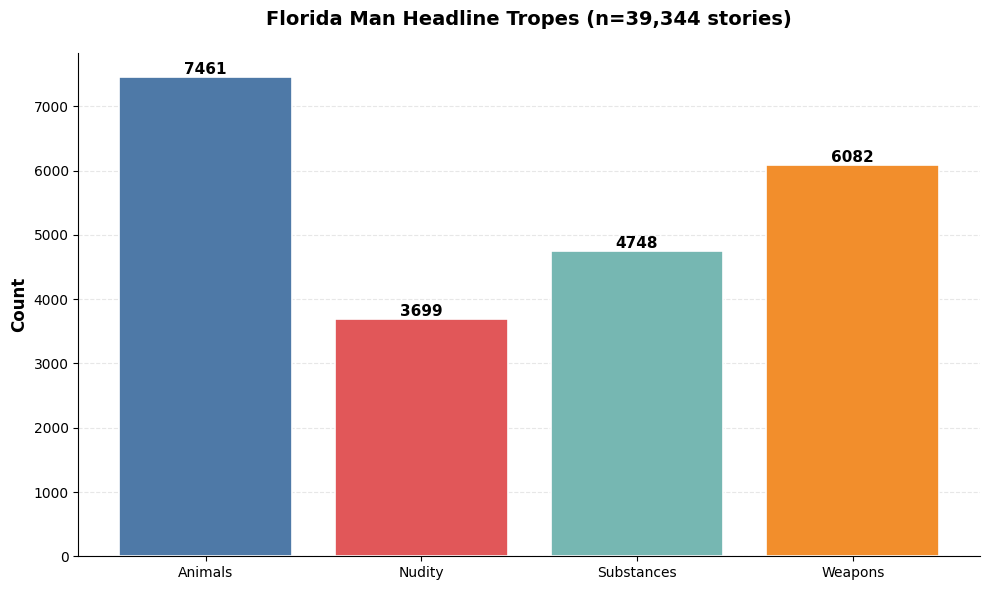

In [8]:

# quick stats
if df is not None and not df.empty:
    print(f"total unique stories: {len(df)}")
    print('\ncategory breakdown:')
    for col in ['has_animals','has_nudity','has_substances','has_weapons']:
        if col in df.columns:
            count = int(df[col].sum())
            pct = (count / len(df)) * 100
            print(f"  {col.replace('has_','')}: {count} ({pct:.1f}%)")
else:
    print('no data to summarize')

# bar chart - overall trope frequency
if df is not None and not df.empty:
    counts = df[['has_animals','has_nudity','has_substances','has_weapons']].sum()
    labels = ['Animals', 'Nudity', 'Substances', 'Weapons']
    values = counts.values

    colors = ['#4e79a7', '#e15759', '#76b7b2', '#f28e2c']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(labels, values, color=colors, edgecolor='white', linewidth=1.2)

    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title(f'Florida Man Headline Tropes (n={len(df):,} stories)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print('no data to plot')


## Deeper analysis

Now that we have the data, we can dig into patterns. How many of these stories have the tropes we're looking for? How many have multiple tropes?


trope count distribution
no tropes: 21564 (54.8%)
one trope: 14176 (36.0%)
two tropes: 3023 (7.7%)
three+ tropes: 581 (1.5%)


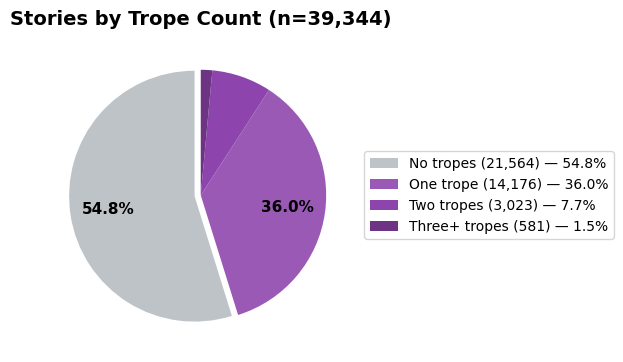

In [9]:
# trope count distribution (pie)
if df is not None and not df.empty:
    print('trope count distribution')

    df['trope_count'] = df[['has_animals','has_nudity','has_substances','has_weapons']].sum(axis=1)

    counts_by_num = [
        ('No tropes', len(df[df.trope_count == 0])),
        ('One trope', len(df[df.trope_count == 1])),
        ('Two tropes', len(df[df.trope_count == 2])),
        ('Three+ tropes', len(df[df.trope_count >= 3]))
    ]

    for label, count in counts_by_num:
        pct = count / len(df) * 100
        print(f"{label.lower()}: {count} ({pct:.1f}%)")

    labels_left = [c[0] for c in counts_by_num]
    values_left = [c[1] for c in counts_by_num]
    # NEW: purple/violet gradient for combination counts (distinct from category colors)
    colors_left = ['#bdc3c7', '#9b59b6', '#8e44ad', '#6c3483']  # gray → light purple → dark purple
    explode = (0.05, 0, 0, 0)
    
    # custom autopct: only show percentage if slice is >= 10%
    def autopct_func(pct):
        return f'{pct:.1f}%' if pct >= 10 else ''
    
    plt.figure(figsize=(6, 6))
    plt.subplots_adjust(top=0.95)
    wedges, texts, autotexts = plt.pie(values_left, labels=None, autopct=autopct_func, startangle=90,
            colors=colors_left, explode=explode, pctdistance=0.7, textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    # legend includes percentages for all slices
    legend_labels = [f"{lab} ({val:,}) — {val/sum(values_left)*100:.1f}%" for lab, val in zip(labels_left, values_left)]
    plt.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.title(f'Stories by Trope Count (n={len(df):,})', fontsize=14, fontweight='bold', pad=10, loc='center')
    plt.tight_layout()
    plt.show()
else:
    print('no data')

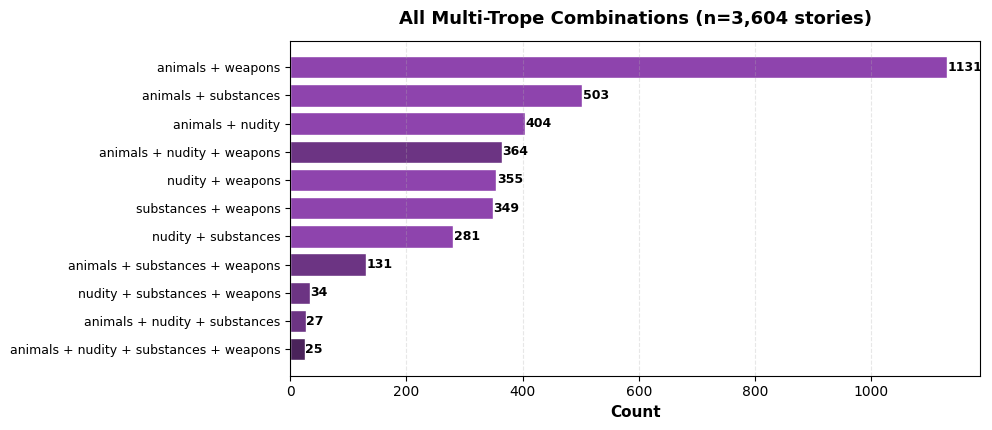

In [10]:
# all multi-trope combinations
if df is not None and not df.empty:
    combos = []
    for _, row in df[df['trope_count'] >= 2].iterrows():
        combo = []
        if row['has_animals']: combo.append('animals')
        if row['has_nudity']: combo.append('nudity')
        if row['has_substances']: combo.append('substances')
        if row['has_weapons']: combo.append('weapons')
        combos.append(' + '.join(combo))

    from collections import Counter
    combo_items = Counter(combos).most_common()

    if combo_items:
        combo_labels = [c[0] for c in combo_items]
        combo_vals = [c[1] for c in combo_items]
        plt.figure(figsize=(10, max(4, len(combo_labels)*0.4)))
        
        # Category colors for single tropes, purple gradient for combinations
        trope_colors_single = {
            'animals': '#4e79a7',
            'nudity': '#e15759',
            'substances': '#76b7b2',
            'weapons': '#f28e2c'
        }
        colors_combo = []
        for lbl in combo_labels:
            trope_num = lbl.count('+') + 1
            if trope_num == 2:
                colors_combo.append('#8e44ad')  # medium purple (2 tropes)
            elif trope_num == 3:
                colors_combo.append('#6c3483')  # dark purple (3 tropes)
            else:  # 4 tropes
                colors_combo.append('#4a235a')  # darkest purple (4 tropes)
        
        bars = plt.barh(range(len(combo_labels)), combo_vals, color=colors_combo, edgecolor='white', linewidth=1.0)
        plt.yticks(range(len(combo_labels)), combo_labels, fontsize=9)
        plt.xlabel('Count', fontsize=11, fontweight='bold')
        plt.title(f'All Multi-Trope Combinations (n={sum(combo_vals):,} stories)', fontsize=13, fontweight='bold', pad=12)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        for i, (bar, val) in enumerate(zip(bars, combo_vals)):
            plt.text(val + 0.5, i, f'{val}', va='center', fontsize=9, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print('no multi-trope combos')
else:
    print('no data')

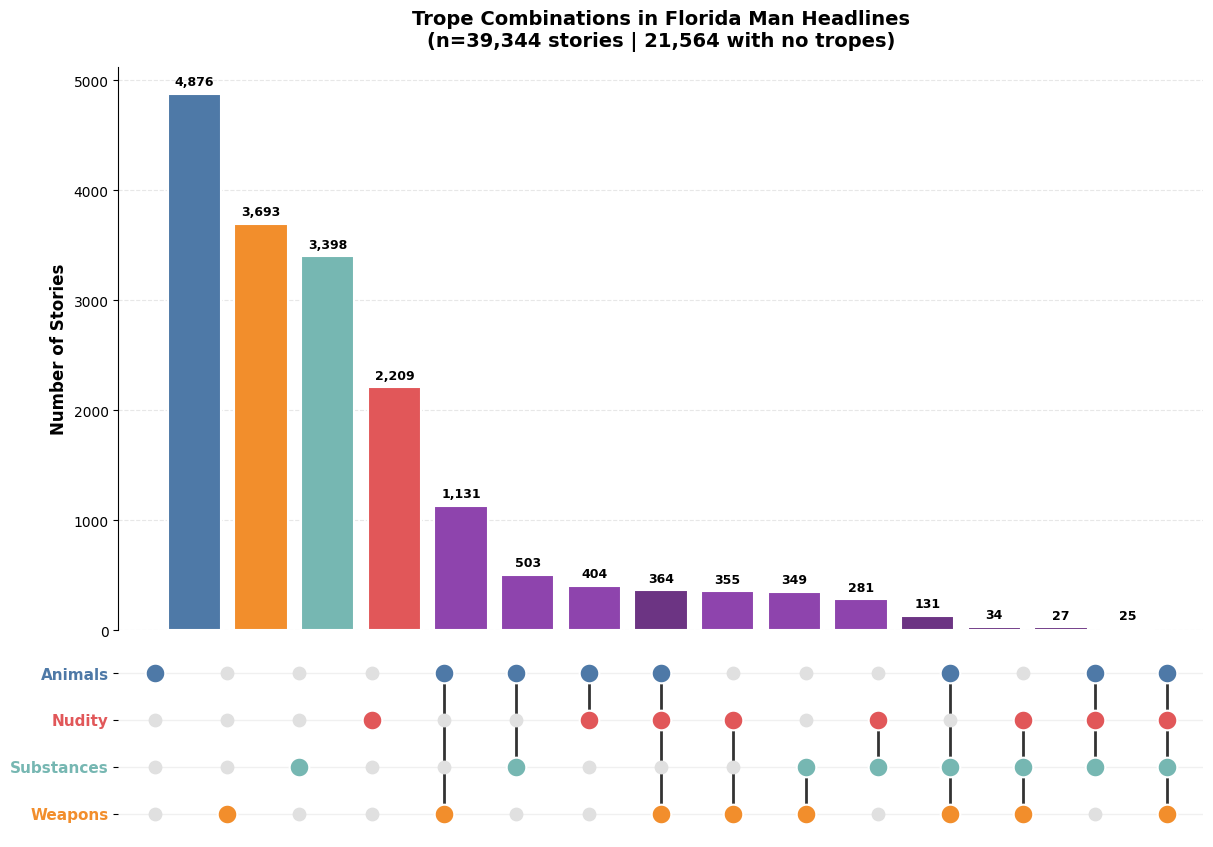


top 10 combinations:
  Animals: 4,876 (12.4%)
  Weapons: 3,693 (9.4%)
  Substances: 3,398 (8.6%)
  Nudity: 2,209 (5.6%)
  Animals + Weapons: 1,131 (2.9%)
  Animals + Substances: 503 (1.3%)
  Animals + Nudity: 404 (1.0%)
  Animals + Nudity + Weapons: 364 (0.9%)
  Nudity + Weapons: 355 (0.9%)
  Substances + Weapons: 349 (0.9%)

  No tropes: 21,564 (54.8%)
  All four tropes: 25


In [11]:
# trope overlap analysis - UpSet-style visualization
# shows all combinations clearly with bars + dot matrix

from itertools import combinations

if df is not None and not df.empty:
    # colors matching the initial bar chart (for dot matrix)
    trope_colors = {
        'Animals': '#4e79a7',
        'Nudity': '#e15759', 
        'Substances': '#76b7b2',
        'Weapons': '#f28e2c'
    }
    trope_cols = ['has_animals', 'has_nudity', 'has_substances', 'has_weapons']
    trope_names = ['Animals', 'Nudity', 'Substances', 'Weapons']
    
    # create combination key for each row
    def get_combo_key(row):
        active = [name for col, name in zip(trope_cols, trope_names) if row[col]]
        return tuple(sorted(active)) if active else ('None',)
    
    df['combo_key'] = df.apply(get_combo_key, axis=1)
    combo_counts = df['combo_key'].value_counts()
    
    # filter to show top combinations (skip "None" for cleaner viz, show separately)
    none_count = combo_counts.get(('None',), 0)
    combo_counts_filtered = combo_counts[combo_counts.index != ('None',)].head(15)
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
    
    # top: bar chart of combination counts
    ax_bar = fig.add_subplot(gs[0])
    x_pos = range(len(combo_counts_filtered))
    
    # Category colors for single tropes, purple gradient for multi-trope combinations
    bar_colors = []
    for combo in combo_counts_filtered.index:
        n = len(combo)
        if n == 1:
            # Use category colors for single-trope combos
            bar_colors.append(trope_colors[combo[0]])
        elif n == 2:
            bar_colors.append('#8e44ad')   # medium purple (pairs)
        elif n == 3:
            bar_colors.append('#6c3483')   # dark purple (triples)
        else:
            bar_colors.append('#4a235a')   # darkest purple (all four)
    
    bars = ax_bar.bar(x_pos, combo_counts_filtered.values, color=bar_colors, 
                      edgecolor='white', linewidth=1.5)
    
    # add value labels
    for i, (bar, val) in enumerate(zip(bars, combo_counts_filtered.values)):
        ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   f'{val:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax_bar.set_ylabel('Number of Stories', fontsize=12, fontweight='bold')
    ax_bar.set_title(f'Trope Combinations in Florida Man Headlines\n(n={len(df):,} stories | {none_count:,} with no tropes)',
                    fontsize=14, fontweight='bold', pad=15)
    ax_bar.set_xticks([])
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['bottom'].set_visible(False)
    ax_bar.grid(axis='y', alpha=0.3, linestyle='--')
    ax_bar.set_axisbelow(True)
    
    # bottom: dot matrix showing which tropes are in each combo (keeps category colors)
    ax_matrix = fig.add_subplot(gs[1])
    
    for i, combo in enumerate(combo_counts_filtered.index):
        for j, trope in enumerate(trope_names):
            if trope in combo:
                ax_matrix.scatter(i, j, s=200, c=trope_colors[trope], zorder=3, edgecolor='white', linewidth=1.5)
            else:
                ax_matrix.scatter(i, j, s=80, c='#e0e0e0', zorder=2)
        
        # draw connecting line for multi-trope combos
        active_indices = [j for j, trope in enumerate(trope_names) if trope in combo]
        if len(active_indices) > 1:
            ax_matrix.plot([i, i], [min(active_indices), max(active_indices)], 
                          c='#333333', linewidth=2, zorder=1)
    
    ax_matrix.set_yticks(range(len(trope_names)))
    ax_matrix.set_yticklabels(trope_names, fontsize=11, fontweight='bold')
    ax_matrix.set_xticks([])
    ax_matrix.set_xlim(-0.5, len(combo_counts_filtered) - 0.5)
    ax_matrix.set_ylim(-0.5, len(trope_names) - 0.5)
    ax_matrix.invert_yaxis()
    ax_matrix.spines['top'].set_visible(False)
    ax_matrix.spines['right'].set_visible(False)
    ax_matrix.spines['bottom'].set_visible(False)
    ax_matrix.spines['left'].set_visible(False)
    
    # color the y-axis labels
    for i, label in enumerate(ax_matrix.get_yticklabels()):
        label.set_color(trope_colors[trope_names[i]])
    
    # add horizontal grid lines
    for j in range(len(trope_names)):
        ax_matrix.axhline(y=j, color='#f0f0f0', linewidth=1, zorder=0)
    
    plt.show()
    
    # print summary
    print('\ntop 10 combinations:')
    for combo, count in combo_counts_filtered.head(10).items():
        label = ' + '.join(combo) if combo != ('None',) else 'No tropes'
        pct = count / len(df) * 100
        print(f"  {label}: {count:,} ({pct:.1f}%)")
    
    print(f"\n  No tropes: {none_count:,} ({none_count/len(df)*100:.1f}%)")
    
    # all four tropes
    all_four = len(df[df[trope_cols].all(axis=1)])
    print(f"  All four tropes: {all_four}")
else:
    print('no data')

## Geographic distribution

Where do these stories come from? Miami? Orlando? Some random swamp town? Location extraction isn't perfect. Many headlines don't mention a specific place and use "Florida Man" for the buzz. But when they do mention, we can see which counties produce the most Florida Man content.

The choropleth map uses county boundaries from the US Census Bureau. Darker blue means more stories. There is also show a bar chart of the top 20 locations for detail.

geographic distribution

stories with specific location: 1937 (4.9%)
stories with generic 'Florida': 37407 (95.1%)
downloading cartographic boundary shapefile (accurate coastlines)...
loaded 67 Florida counties


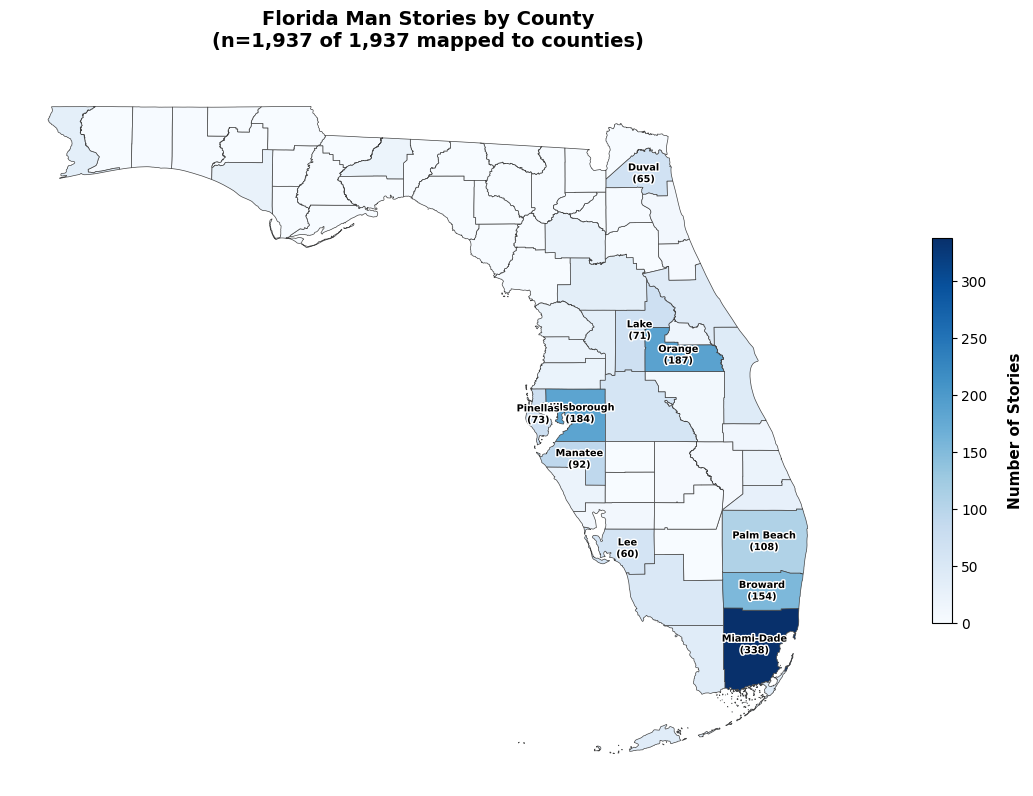


top 10 counties:
  Miami-Dade County: 338
  Orange County: 187
  Hillsborough County: 184
  Broward County: 154
  Palm Beach County: 108
  Manatee County: 92
  Pinellas County: 73
  Lake County: 71
  Duval County: 65
  Lee County: 60


In [12]:
# geographic distribution — Florida county choropleth map
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np

# Reload and clean data if needed (kernel was restarted after installing geopandas)
try:
    df
except NameError:
    df = pd.read_csv('florida_man_scrape.csv')
    df = clean_florida_data(df)
    print()

if df is not None and not df.empty and 'location_hint' in df.columns:
    print('geographic distribution\n')
    
    # count locations, excluding generic "Florida"
    specific_locs = df[df['location_hint'] != 'Florida']['location_hint'].value_counts()
    total_specific = len(df[df['location_hint'] != 'Florida'])
    
    print(f"stories with specific location: {total_specific} ({total_specific/len(df)*100:.1f}%)")
    print(f"stories with generic 'Florida': {len(df[df['location_hint'] == 'Florida'])} ({len(df[df['location_hint'] == 'Florida'])/len(df)*100:.1f}%)")
    
    # --- CHOROPLETH MAP ---
    try:
        # Use CARTOGRAPHIC BOUNDARY files - these have accurate coastlines clipped to shoreline
        # Much better for visualization than TIGER files which include water areas
        url = "https://www2.census.gov/geo/tiger/GENZ2024/shp/cb_2024_us_county_500k.zip"
        print("downloading cartographic boundary shapefile (accurate coastlines)...")
        us_counties = gpd.read_file(url)
        fl_counties = us_counties[us_counties['STATEFP'] == '12'].copy()
        print(f"loaded {len(fl_counties)} Florida counties")
        
        # Expanded city-to-county mapping for Florida
        city_to_county = {
            'Miami': 'Miami-Dade', 'Orlando': 'Orange', 'Tampa': 'Hillsborough',
            'Jacksonville': 'Duval', 'Tallahassee': 'Leon', 'St. Petersburg': 'Pinellas',
            'Saint Petersburg': 'Pinellas', 'Fort Lauderdale': 'Broward', 'Hialeah': 'Miami-Dade',
            'Pembroke Pines': 'Broward', 'Hollywood': 'Broward', 'Gainesville': 'Alachua',
            'Boca Raton': 'Palm Beach', 'Sarasota': 'Sarasota', 'Naples': 'Collier',
            'Fort Myers': 'Lee', 'Pensacola': 'Escambia', 'Daytona Beach': 'Volusia',
            'St. Augustine': 'St. Johns', 'Saint Augustine': 'St. Johns', 'Clearwater': 'Pinellas',
            'Ocala': 'Marion', 'Lakeland': 'Polk', 'Winter Park': 'Orange',
            'Kissimmee': 'Osceola', 'Delray Beach': 'Palm Beach', 'West Palm Beach': 'Palm Beach',
            'Palm Beach': 'Palm Beach', 'Coral Gables': 'Miami-Dade', 'Key West': 'Monroe',
            'Panama City': 'Bay', 'Port St. Lucie': 'St. Lucie', 'Port Saint Lucie': 'St. Lucie',
            'Sanford': 'Seminole', 'Boynton Beach': 'Palm Beach', 'Cape Coral': 'Lee',
            'Bradenton': 'Manatee', 'Pompano Beach': 'Broward', 'Deerfield Beach': 'Broward',
            'North Miami': 'Miami-Dade', 'Homestead': 'Miami-Dade', 'Aventura': 'Miami-Dade',
            'Doral': 'Miami-Dade', 'Miramar': 'Broward', 'Sunrise': 'Broward',
            'Coral Springs': 'Broward', 'Jupiter': 'Palm Beach', 'Palm Bay': 'Brevard',
            'Melbourne': 'Brevard', 'Vero Beach': 'Indian River', 'Stuart': 'Martin',
            'Fort Pierce': 'St. Lucie', 'Winter Haven': 'Polk', 'Bartow': 'Polk',
            'Brandon': 'Hillsborough', 'New Port Richey': 'Pasco', 'Spring Hill': 'Hernando',
            'The Villages': 'Sumter', 'Leesburg': 'Lake', 'Key Largo': 'Monroe',
            'Marco Island': 'Collier', 'Bonita Springs': 'Lee', 'Estero': 'Lee',
            # Additional cities
            'Coconut Creek': 'Broward', 'Margate': 'Broward', 'Plantation': 'Broward',
            'Davie': 'Broward', 'Weston': 'Broward', 'Tamarac': 'Broward',
            'Lauderhill': 'Broward', 'Oakland Park': 'Broward', 'Hallandale Beach': 'Broward',
            'Apopka': 'Orange', 'Altamonte Springs': 'Seminole', 'Oviedo': 'Seminole',
            'Clermont': 'Lake', 'Winter Garden': 'Orange', 'Ocoee': 'Orange',
            'Lake Worth': 'Palm Beach', 'Lake Worth Beach': 'Palm Beach',
            'Greenacres': 'Palm Beach', 'Wellington': 'Palm Beach', 'Royal Palm Beach': 'Palm Beach',
            'Riviera Beach': 'Palm Beach', 'Lake Park': 'Palm Beach', 'Lantana': 'Palm Beach',
            'Sebring': 'Highlands', 'Okeechobee': 'Okeechobee', 'Clewiston': 'Hendry',
            'Belle Glade': 'Palm Beach', 'Pahokee': 'Palm Beach',
            'Inverness': 'Citrus', 'Crystal River': 'Citrus', 'Brooksville': 'Hernando',
            'Zephyrhills': 'Pasco', 'Dade City': 'Pasco', 'Land O\' Lakes': 'Pasco',
            'Wesley Chapel': 'Pasco', 'Lutz': 'Hillsborough', 'Plant City': 'Hillsborough',
            'Ruskin': 'Hillsborough', 'Sun City Center': 'Hillsborough',
            'Largo': 'Pinellas', 'Dunedin': 'Pinellas', 'Tarpon Springs': 'Pinellas',
            'Safety Harbor': 'Pinellas', 'Pinellas Park': 'Pinellas', 'Seminole': 'Pinellas',
            'Venice': 'Sarasota', 'North Port': 'Sarasota', 'Englewood': 'Sarasota',
            'Port Charlotte': 'Charlotte', 'Punta Gorda': 'Charlotte',
            'Lehigh Acres': 'Lee', 'Fort Myers Beach': 'Lee', 'Sanibel': 'Lee',
            'Immokalee': 'Collier', 'Golden Gate': 'Collier', 'Ave Maria': 'Collier',
            'Islamorada': 'Monroe', 'Marathon': 'Monroe', 'Tavernier': 'Monroe',
            'Titusville': 'Brevard', 'Cocoa': 'Brevard', 'Cocoa Beach': 'Brevard',
            'Rockledge': 'Brevard', 'Merritt Island': 'Brevard', 'Satellite Beach': 'Brevard',
            'New Smyrna Beach': 'Volusia', 'Ormond Beach': 'Volusia', 'DeLand': 'Volusia',
            'Deltona': 'Volusia', 'Port Orange': 'Volusia', 'Edgewater': 'Volusia',
            'St. Cloud': 'Osceola', 'Saint Cloud': 'Osceola', 'Celebration': 'Osceola',
            'Haines City': 'Polk', 'Auburndale': 'Polk', 'Lake Wales': 'Polk',
            'Bartow': 'Polk', 'Mulberry': 'Polk', 'Frostproof': 'Polk',
            'Crestview': 'Okaloosa', 'Fort Walton Beach': 'Okaloosa', 'Destin': 'Okaloosa',
            'Niceville': 'Okaloosa', 'Navarre': 'Santa Rosa', 'Milton': 'Santa Rosa',
            'Gulf Breeze': 'Santa Rosa', 'Pace': 'Santa Rosa',
            'Fernandina Beach': 'Nassau', 'Yulee': 'Nassau',
            'St. Marys': 'Nassau', 'Callahan': 'Nassau',
            'Palm Coast': 'Flagler', 'Bunnell': 'Flagler', 'Flagler Beach': 'Flagler',
            'Orange Park': 'Clay', 'Green Cove Springs': 'Clay', 'Middleburg': 'Clay',
            'Fleming Island': 'Clay', 'Keystone Heights': 'Clay',
            'Starke': 'Bradford', 'Lake Butler': 'Union', 'Macclenny': 'Baker',
            'Live Oak': 'Suwannee', 'Lake City': 'Columbia', 'Jasper': 'Hamilton',
            'Madison': 'Madison', 'Perry': 'Taylor', 'Cross City': 'Dixie',
            'Chiefland': 'Levy', 'Williston': 'Levy', 'Trenton': 'Gilchrist',
            'Newberry': 'Alachua', 'High Springs': 'Alachua', 'Archer': 'Alachua',
            'Palatka': 'Putnam', 'Crescent City': 'Putnam', 'Interlachen': 'Putnam',
            'Marianna': 'Jackson', 'Chipley': 'Washington', 'Bonifay': 'Holmes',
            'DeFuniak Springs': 'Walton', 'Freeport': 'Walton', 'Santa Rosa Beach': 'Walton',
            'Lynn Haven': 'Bay', 'Callaway': 'Bay', 'Springfield': 'Bay',
            'Port St. Joe': 'Gulf', 'Wewahitchka': 'Gulf', 'Apalachicola': 'Franklin',
            'Carrabelle': 'Franklin', 'Crawfordville': 'Wakulla', 'Sopchoppy': 'Wakulla',
            'Quincy': 'Gadsden', 'Havana': 'Gadsden', 'Chattahoochee': 'Gadsden',
            'Monticello': 'Jefferson', 'Blountstown': 'Calhoun', 'Bristol': 'Liberty',
            'Sneads': 'Jackson', 'Graceville': 'Jackson', 'Cottondale': 'Jackson'
        }
        
        # Map locations to counties and track unmapped
        county_counts = {}
        unmapped_locs = {}
        
        for loc, count in specific_locs.items():
            city = loc.replace(', FL', '').replace(' County', '').strip()
            
            if city in fl_counties['NAME'].values:
                county = city
            elif city in city_to_county:
                county = city_to_county[city]
            else:
                county = None
                for c in fl_counties['NAME'].values:
                    if c.lower() in city.lower() or city.lower() in c.lower():
                        county = c
                        break
            
            if county:
                county_counts[county] = county_counts.get(county, 0) + count
            else:
                unmapped_locs[loc] = count
        
        # Merge counts with geodataframe
        fl_counties['story_count'] = fl_counties['NAME'].map(county_counts).fillna(0)
        
        # Create the choropleth map
        fig, ax_map = plt.subplots(figsize=(14, 10))
        
        # Plot all counties including Monroe (Keys) - cartographic boundary has accurate shapes
        fl_counties.plot(column='story_count', ax=ax_map, legend=True,
                        cmap='Blues', edgecolor='#444444', linewidth=0.5,
                        legend_kwds={
                            'label': 'Number of Stories',
                            'shrink': 0.5,
                            'pad': 0.08,
                            'aspect': 20
                        })
        
        # Let geopandas set the bounds automatically for the data
        ax_map.set_aspect('equal')
        plt.axis('off')
        
        # Adjust colorbar label position
        cbar = ax_map.get_figure().axes[-1]
        cbar.set_ylabel('Number of Stories', fontsize=11, fontweight='bold', labelpad=15)
        
        # Add county labels for top counties
        top_counties = fl_counties.nlargest(10, 'story_count')
        for idx, row in top_counties.iterrows():
            centroid = row.geometry.centroid
            ax_map.annotate(f"{row['NAME']}\n({int(row['story_count'])})", 
                           xy=(centroid.x, centroid.y),
                           ha='center', va='center', fontsize=7, fontweight='bold',
                           color='black', path_effects=[
                               path_effects.withStroke(linewidth=2, foreground='white')
                           ])
        
        # Title - now shows all stories mapped
        mapped_total = sum(county_counts.values())
        ax_map.set_title(f'Florida Man Stories by County\n(n={mapped_total:,} of {total_specific:,} mapped to counties)',
                         fontsize=14, fontweight='bold', pad=20)
        
        plt.show()
        
        # Print top counties
        print(f'\ntop 10 counties:')
        for county, count in sorted(county_counts.items(), key=lambda x: -x[1])[:10]:
            print(f"  {county} County: {count}")
        
        # Show unmapped locations if any
        if unmapped_locs:
            unmapped_total = sum(unmapped_locs.values())
            print(f"\n⚠ {unmapped_total} stories not mapped ({len(unmapped_locs)} unique locations):")
            for loc, count in sorted(unmapped_locs.items(), key=lambda x: -x[1])[:10]:
                print(f"  {loc}: {count}")
            
    except Exception as e:
        print(f"could not load shapefile: {e}")
        import traceback
        traceback.print_exc()
        print("(run the bar chart cell below for location breakdown)")
else:
    print('no data or no location_hint column')

top 15 locations:
  Miami, FL: 306
  Tampa, FL: 166
  Orlando, FL: 128
  Manatee County, FL: 80
  Lake County, FL: 68
  Jacksonville, FL: 64
  Orange County, FL: 55
  Broward County, FL: 50
  Palm Beach, FL: 46
  Clearwater, FL: 42
  Polk County, FL: 41
  Naples, FL: 36
  The Villages, FL: 35
  Key West, FL: 34
  Fort Lauderdale, FL: 33


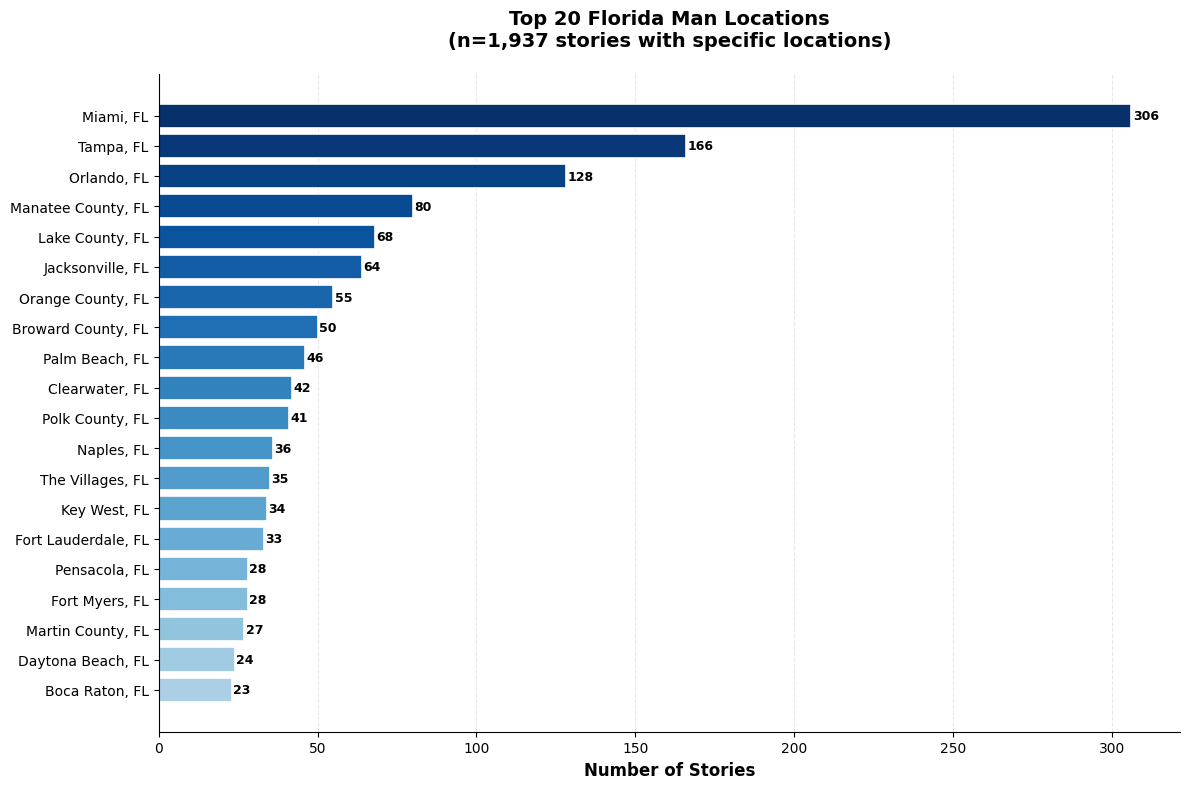

In [13]:
# geographic distribution — top locations bar chart
if df is not None and not df.empty and 'location_hint' in df.columns:
    # count locations, excluding generic "Florida"
    specific_locs = df[df['location_hint'] != 'Florida']['location_hint'].value_counts()
    
    if len(specific_locs) > 0:
        print('top 15 locations:')
        for loc, count in specific_locs.head(15).items():
            print(f"  {loc}: {count}")
        
        # visualization - top 20 locations
        top_locs = specific_locs.head(20)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # color gradient - darker blue = more stories
        colors = plt.cm.Blues([(0.3 + 0.7 * (i / len(top_locs))) for i in range(len(top_locs), 0, -1)])
        
        bars = ax.barh(range(len(top_locs)), top_locs.values, color=colors,
                       edgecolor='white', linewidth=1.2)
        ax.set_yticks(range(len(top_locs)))
        ax.set_yticklabels(top_locs.index, fontsize=10)
        ax.set_xlabel('Number of Stories', fontsize=12, fontweight='bold')
        ax.set_title(f'Top 20 Florida Man Locations\n(n={len(df[df["location_hint"] != "Florida"]):,} stories with specific locations)',
                     fontsize=14, fontweight='bold', pad=20)
        ax.invert_yaxis()
        
        # styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # add value labels
        for i, (bar, val) in enumerate(zip(bars, top_locs.values)):
            ax.text(val + 0.5, i, f'{val}', va='center', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("(no specific locations found)")
else:
    print('no data or no location_hint column')

## Word frequency analysis

What words show up most often in Florida Man headlines?

We must filter out the obvious stuff: "florida", "man", "arrested", "police". And what's left tells us something about the nature of these stories.

The viridis color gradient makes it easier to see the frequency drop-off. Top words appear in 40-60 headlines. By rank 20, we're down to single digits.

most common words in florida man headlines

  naked: 918
  cops: 862
  steals: 791
  shoots: 744
  alligator: 733
  house: 703
  school: 683
  wife: 683
  stealing: 658
  child: 648
  girlfriend: 648
  trying: 622
  fire: 618
  shot: 596
  drunk: 595


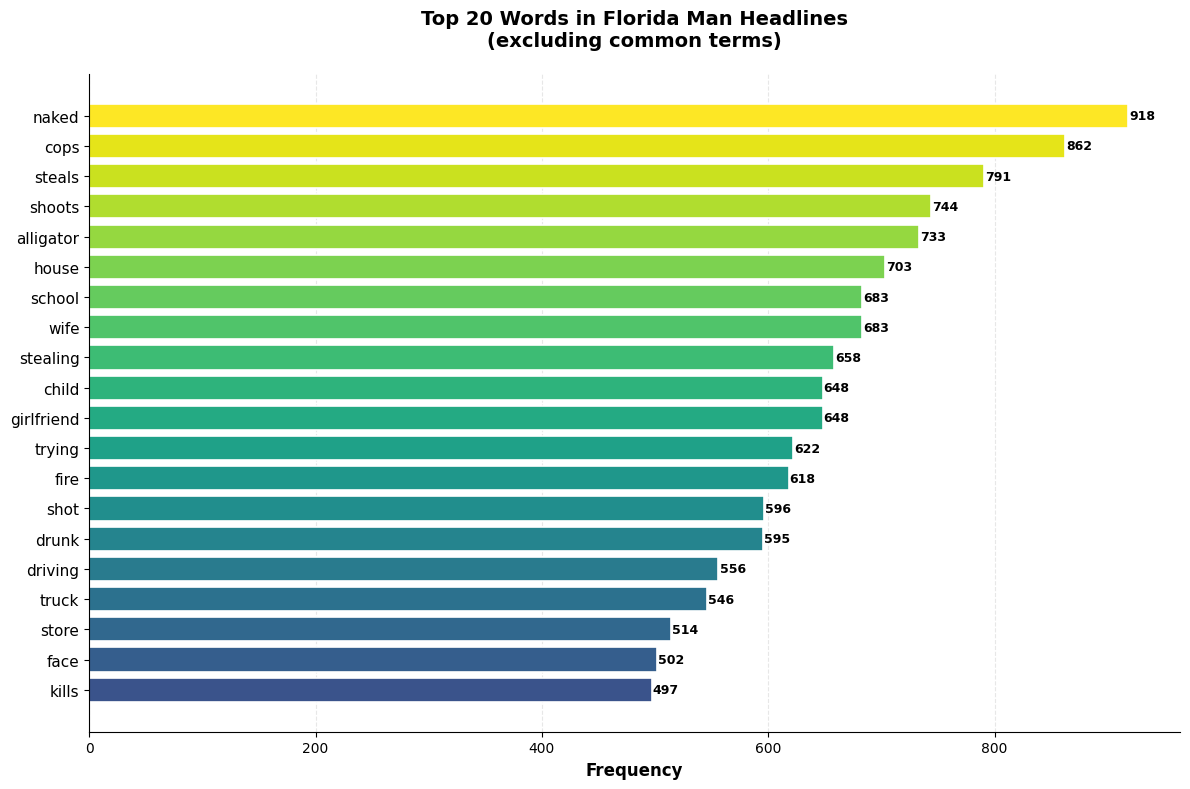

In [14]:
# headline linguistics — word frequency
if df is not None and not df.empty:
    print('most common words in florida man headlines\n')
    
    # combine all headlines, lowercase, split
    all_words = []
    for headline in df['headline'].dropna():
        words = re.findall(r'\b[a-z]{4,}\b', headline.lower())  # 4+ letter words
        all_words.extend(words)
    
    # comprehensive stopwords: common English + news/crime terms + Florida-specific
    stopwords = {
        # florida man basics
        'florida', 'floridaman', 'floridawoman', 'man', 'woman', 'male', 'female',
        # crime/news boilerplate
        'arrested', 'police', 'deputies', 'deputy', 'sheriff', 'officer', 'officers',
        'charged', 'accused', 'allegedly', 'charges', 'facing', 'faces', 'criminal',
        'jail', 'prison', 'court', 'judge', 'sentenced', 'convicted', 'guilty',
        'suspect', 'victim', 'report', 'reports', 'reported', 'officials', 'authorities',
        # common verbs/actions
        'says', 'said', 'told', 'tells', 'claims', 'found', 'caught', 'gets', 'tries',
        'tried', 'went', 'goes', 'going', 'came', 'comes', 'coming', 'took', 'takes',
        'made', 'makes', 'making', 'called', 'calls', 'seen', 'video', 'shows',
        # prepositions/conjunctions/articles
        'after', 'before', 'during', 'while', 'when', 'where', 'about', 'into',
        'from', 'with', 'without', 'over', 'under', 'through', 'between', 'against',
        'this', 'that', 'these', 'those', 'their', 'them', 'they', 'what', 'which',
        'been', 'being', 'have', 'having', 'does', 'doing', 'done', 'were', 'because',
        'himself', 'herself', 'themselves', 'someone', 'something', 'another', 'other',
        # time words
        'year', 'years', 'month', 'months', 'week', 'weeks', 'days', 'time', 'times',
        'first', 'second', 'third', 'last', 'next', 'then', 'just', 'still', 'already',
        # numbers written out
        'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
        # misc filler
        'more', 'most', 'some', 'many', 'much', 'very', 'also', 'only', 'even', 'back',
        'home', 'away', 'here', 'there', 'down', 'inside', 'outside', 'near', 'later',
        'allegedly', 'according', 'incident', 'case', 'local', 'county', 'state', 'area'
    }
    
    interesting_words = [w for w in all_words if w not in stopwords]
    
    from collections import Counter
    if interesting_words:
        top_words = Counter(interesting_words).most_common(20)
        
        # print text summary
        for word, count in top_words[:15]:
            print(f"  {word}: {count}")
        
        # visualization - word cloud style bar chart
        fig, ax = plt.subplots(figsize=(12, 8))
        
        words = [w[0] for w in top_words]
        counts = [w[1] for w in top_words]
        
        # color gradient
        colors = plt.cm.viridis(range(255, 50, -int(205/len(words))))
        
        bars = ax.barh(range(len(words)), counts, color=colors, 
                       edgecolor='white', linewidth=1.2)
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=11)
        ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title('Top 20 Words in Florida Man Headlines\n(excluding common terms)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.invert_yaxis()
        
        # styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # add value labels
        for i, (bar, val) in enumerate(zip(bars, counts)):
            ax.text(val + 1, i, f'{val}', va='center', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("  (no words found)")
else:
    print('no data')

## Zero-trope stories

Here's where it gets interesting. Even with expanded regex patterns, about half the stories don't match any of our four categories. That's a lot.

These are the "pure" florida man stories. No animals, no nudity, no drugs, no weapons. Just pure absurdity. Theft of weird objects. Bizarre excuses. Creative property crimes. The stuff that's hard to categorize but unmistakably *Florida Man*.

This might be the most important finding: the meme is real, but it's not the whole picture.

In [15]:
# the "pure" florida man stories — no standard tropes
import random

if df is not None and not df.empty:
    pure = df[df['trope_count'] == 0]
    has_tropes = df[df['trope_count'] > 0]
    
    if len(pure) > 0:
        pct_pure = len(pure) / len(df) * 100
        pct_troped = len(has_tropes) / len(df) * 100
        
        print(f'Zero-Trope Stories: The "Pure" Florida Man')
        print(f'({len(pure):,} stories, {pct_pure:.1f}% of dataset)\n')
        
        print(f'Random Sample:')
        print(f'(no animals, nudity, substances, or weapons)\n')
        
        # Random sample - 8 headlines
        sample = pure.copy()
        sample['len'] = sample['headline'].str.len()
        sample = sample[(sample['len'] > 50) & (sample['len'] < 200)].sample(n=min(8, len(sample)), random_state=None)
        
        for _, row in sample.iterrows():
            print(f"  • {row['headline']}")
        
        # Personal favorites - curated headlines (randomly pick 8)
        print(f'\n\nPersonal Favorites (8 of 27):\n')
        all_favorites = [
            "Florida woman backing pickup out of driveway hits gas instead of brake, plows into house across the street -- all the way into the house",
            "Florida man accused of assaulting girl lured away from birthday party",
            "Florida Woman thought to have stuffed 93 year-old dead Mom in freezer",
            "Florida Man, Sheriff's office volunteer accused of selling oxycodone from patrol car",
            "Police: Florida man claims he's Jesus, kisses a minor in gym locker room",
            "Florida woman assaults TSA agent after fellow passenger accidentally takes her laptop",
            "Florida man gropes technician who was fingerprinting him for disorderly conduct charge",
            "Florida Man uses a blow torch to open an ATM... instead he accidentally welds it shut",
            "Florida Man (Woman) Drops Baby On Head After Running Around In Traffic",
            "Florida Man tries to steal chainsaw by sticking it down his pants.",
            "Florida man opens beaches in the middle of a pandemic",
            "Police: Florida Man arrested after jumping onto moving train in Downtown Pensacola",
            "Florida man arrested after fight with parent at elementary school, deputies say",
            "Florida Woman With $100K in Car Reportedly Crashes into Concert, Hits Two People",
            "Florida Man atee Mutilated By Someone Who Etched 'Trump' Onto Its Back",
            "Florida Man gets trapped under a lawnmower in pond, dies",
            "Florida woman charged for assaulting man in fight over masks on flight",
            "Florida man gets bitten on face by water moccasin he kept in bed.",
            "Florida man shits himself after attacking sheriff with bible",
            "Florida Man Eats Phone in Protest of Child Molestation",
            "Florida man jailed after throwing McDonald's bag with hamburgers at dad",
            "Florida Man facing federal charges spread white nationalist hate, lived with his mom and dad in the suburbs",
            "Florida Woman sues school district because she was banned as a volunteer due to being an OlnyFans Model.",
            "Florida man spits on boy in restaurant, says 'you now have coronavirus'",
            "Florida man charged with hate crimes for 'racially-motivated' attack against Black driver",
            "Florida man wrongfully convicted for 3 decades on his release: 'I never stopped believing'",
            "Florida Woman offers ex-husband in home sale: He'll cook and clean",
        ]
        
        # Randomly pick 8 favorites
        selected_favorites = random.sample(all_favorites, 8)
        for headline in selected_favorites:
            print(f"  • {headline}")
        
    else:
        print("(all stories match at least one trope)")
else:
    print('no data')

Zero-Trope Stories: The "Pure" Florida Man
(21,564 stories, 54.8% of dataset)

Random Sample:
(no animals, nudity, substances, or weapons)

  • Florida man bit off part of friend's ear during Key West hotel brawl
  • Submission for the florida man challenge: man dies in explosion after attempting to microwave a microwave.
  • Florida Man Arrested For Calling 911 Because 'Wife Wouldn't Go To Bed'
  • Florida woman is arrested after harassing her 'love rival'
  • Florida Man Rapes Woman To Get To Prison And Go After His Son's Killer
  • Florida Man hockey team wants to keep opposing fans out of their arena
  • Florida Man Podcast #36: Three Hungry Criminals and a Hide &amp; Seek Loser
  • Florida Man To Stare At Ted Cruz's Mouth For Two Hours Straight


Personal Favorites (8 of 27):

  • Florida Man Eats Phone in Protest of Child Molestation
  • Florida Woman thought to have stuffed 93 year-old dead Mom in freezer
  • Florida man shits himself after attacking sheriff with bible
  • Flori

## The absurdity index

Hypothesis: weirder stories need longer, more detailed headlines.

Think about it. "Florida Man Arrested" is boring. But "Florida Man Breaks Into Mansion, Cooks Steak, Gets Caught Because Homeowner Got Phone Alerts An Ocean Away" tells a complete story (and gets more clicks).

Here, we calculate calculates average headline length and word count to then show the longest headlines. These are often the most specific and bizarre stories. We also check if there's a correlation between trope count and headline length.

(Spoiler: not really. Absurdity transcends categories.)

In [16]:
# the absurdity index — headline length as proxy for weirdness
# hypothesis: weirder stories need longer, more specific headlines
if df is not None and not df.empty:
    print('headline complexity:\n')
    
    # Clean HTML entities first
    df['headline_clean'] = df['headline'].str.replace('&amp;', '&', regex=False)
    df['headline_clean'] = df['headline_clean'].str.replace('&lt;', '<', regex=False)
    df['headline_clean'] = df['headline_clean'].str.replace('&gt;', '>', regex=False)
    df['headline_clean'] = df['headline_clean'].str.replace('&quot;', '"', regex=False)
    
    df['headline_length'] = df['headline_clean'].str.len()
    df['word_count'] = df['headline_clean'].str.split().str.len()
    
    print(f"avg headline length: {df['headline_length'].mean():.0f} characters")
    print(f"avg word count: {df['word_count'].mean():.1f} words")
    
    # Filter for quality headlines: must look like actual news
    quality_long = df[
        (df['headline_length'] > 100) &  # Long enough to be interesting
        (df['headline_length'] < 280) &  # Not absurdly long run-ons
        (df['word_count'] < 45) &  # Reasonable word count
        (~df['headline_clean'].str.contains(r'\bI\s+(?:met|did|think|find|wanna|want to)\b', case=False, regex=True)) &  # No personal
        (~df['headline_clean'].str.contains(r'piece of shit|go fuck|swingers|Would you watch', case=False, regex=True)) &  # No rants
        (~df['headline_clean'].str.contains(r'Not a news story|Hey,? everybody', case=False, regex=True)) &  # No meta posts
        (~df['headline_clean'].str.contains(r'Building 7|9/11 anniversary|tabloid state|tabloid people', case=False, regex=True)) &  # No commentary
        (~df['headline_clean'].str.contains(r'http://|https://|Read more:', case=False, regex=True)) &  # No URLs in headlines
        (~df['headline_clean'].str.contains(r'Trump, Clinton|Manafort|FBI concealed', case=False, regex=True)) &  # No political deep dives
        (df['headline_clean'].str.match(r'^[A-Z"\']', na=False))  # Starts like a headline
    ].drop_duplicates(subset='headline_clean').nlargest(10, 'headline_length')
    
    print('\nlongest quality headlines (absurdity indicators):\n')
    for idx, row in quality_long[['headline_clean','trope_count']].iterrows():
        tropes = f"({int(row['trope_count'])} tropes)" if pd.notna(row['trope_count']) else ""
        print(f"  • {row['headline_clean']} {tropes}")
    
    # correlation: do multi-trope stories have longer headlines?
    if 'trope_count' in df.columns:
        avg_by_tropes = df.groupby('trope_count')['headline_length'].mean()
        print('\navg headline length by trope count:')
        for tropes, avg_len in avg_by_tropes.items():
            print(f"  {int(tropes)} tropes: {avg_len:.0f} chars")
else:
    print('no data')

headline complexity:

avg headline length: 78 characters
avg word count: 13.0 words

longest quality headlines (absurdity indicators):

  • Florida Man (City spokesman) posted sensitive emails regarding local and federal criminal investigations on the City of West Palm Beach’s website for three days; exposing the targets of drug stings, the identities of detectives’ confidential informants and undercover officers. (1 tropes)
  • Florida Man: "Trespassing Tire Dumper Caught Shooting at an Alligator FWC officers patrolling private property, where they previously discovered thousands of tires dumped, witnessed a man enter the property and begin shooting at an alligator from the window of his truc (2 tropes)
  • Florida Man and Florida Woman couple with 102 complaints by neighbors against them for continual and intentional harassment since January 2021 and placed on Sheriff's High Intensity Target (S.H.I.T.) List arrested after the couple failed to put a stop to the complaints (1 tropes)
 


## Seasonal trends
The headlines show interesting patterns throughout the year. The hotter it gets, the crazier the stories seem to become. After all, they don’t call it the Miami Heat for nothing.

The chart below highlights these trends, making it easy to spot seasonal changes.

publication timeline

stories with dates: 39344 (100.0%)
date range: 2014-01-01 to 2025-12-11

by month (aggregated across all years):
  January: 3509
  February: 3223
  March: 3762
  April: 3583
  May: 3485
  June: 3055
  July: 3508
  August: 3403
  September: 3051
  October: 3054
  November: 2620
  December: 3091


/var/folders/b2/nk4ybyms6kg2d8lmwyqh28kh0000gn/T/ipykernel_21181/2948022072.py:34: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dated['year_month'] = dated['parsed_date'].dt.to_period('M')


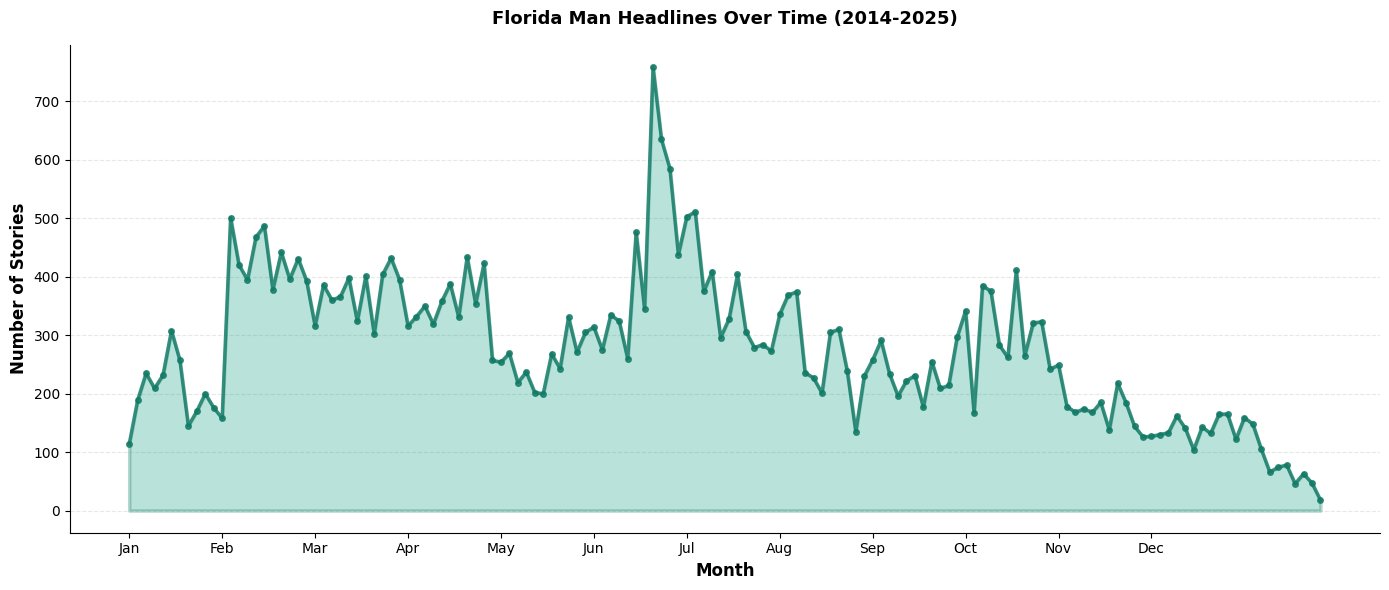

In [17]:
# temporal patterns — when were these stories published?
if df is not None and not df.empty and 'date' in df.columns:
    print('publication timeline\n')
    
    # create a copy to avoid modifying the original
    dated = df[df['date'].notna()].copy()
    dated['parsed_date'] = pd.to_datetime(dated['date'], errors='coerce', utc=True)
    dated = dated[dated['parsed_date'].notna()]
    
    if len(dated) > 0:
        print(f"stories with dates: {len(dated)} ({len(dated)/len(df)*100:.1f}%)")
        print(f"date range: {dated['parsed_date'].min().strftime('%Y-%m-%d')} to {dated['parsed_date'].max().strftime('%Y-%m-%d')}")
        
        # year breakdown
        dated['year'] = dated['parsed_date'].dt.year
        year_counts = dated['year'].value_counts().sort_index(ascending=False)
        
        # aggregate by calendar month (across all years)
        dated['month'] = dated['parsed_date'].dt.month
        month_counts_agg = dated['month'].value_counts().sort_index()
        
        print('\nby month (aggregated across all years):')
        import calendar
        for month_num in range(1, 13):
            if month_num in month_counts_agg.index:
                count = month_counts_agg[month_num]
                month_name = calendar.month_name[month_num]
                print(f'  {month_name}: {count}')

        # visualization - filled area chart for full 2014-2025 timeline
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # monthly aggregation (year-month) across entire timeline for the chart
        dated['year_month'] = dated['parsed_date'].dt.to_period('M')
        month_counts = dated['year_month'].value_counts().sort_index()
        
        x_vals = range(len(month_counts))
        y_vals = month_counts.values
        
        # filled area chart with line - using teal/green color
        ax.fill_between(x_vals, y_vals, alpha=0.3, color='#16a085', edgecolor='#117a65', linewidth=2.5)
        ax.plot(x_vals, y_vals, marker='o', linewidth=2.5, markersize=4, color='#117a65', alpha=0.8)
        
        # set x-axis ticks - show 12 months (Jan-Dec)
        month_names = [calendar.month_abbr[i] for i in range(1, 13)]
        tick_interval = max(1, len(month_counts) // 12)
        tick_positions = list(range(0, min(len(month_counts), len(month_names) * tick_interval), tick_interval))
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(month_names[:len(tick_positions)], rotation=0, ha='center', fontsize=10)
        
        ax.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Stories', fontsize=12, fontweight='bold')
        ax.set_title('Florida Man Headlines Over Time (2014-2025)', fontsize=13, fontweight='bold', pad=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        plt.tight_layout()
        plt.show()
    else:
        print("(no parseable dates)")
else:
    print('no data')
